<a href="https://colab.research.google.com/github/shahrooz-coder/freelancer/blob/main/heart_failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# from lightning.pytorch.callbacks.early_stopping import EarlyStopping

#Data loading

In [2]:
URL = "https://raw.githubusercontent.com/shahrooz-coder/freelancer/main/heart.csv"
df = pd.read_csv(URL)

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


# Preproccessing

In [6]:
# Seperate features and label
df_features = df.drop("HeartDisease", axis=1)
df_label = df["HeartDisease"]
# Seperate numerical and categorial features
numeric_cols = df_features.select_dtypes(include="number").columns
categorical_cols = df_features.select_dtypes(include="object").columns

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_features_numeric_cols = scaler.fit_transform(df_features[numeric_cols])
# Change array to dataframe
df_features_numeric_cols = pd.DataFrame(df_features_numeric_cols, columns=numeric_cols)

In [8]:
ohe = OneHotEncoder()
df_features_categorical_cols = ohe.fit_transform(df_features[categorical_cols])
# for better combination we should change it to Dataframe
df_features_categorical_cols = pd.DataFrame(
    df_features_categorical_cols.toarray(), columns=ohe.get_feature_names_out()
)

In [9]:
# Constructing final dataframe
df_features = pd.concat(
    [df_features_numeric_cols, df_features_categorical_cols], axis=1
)

In [10]:
df_features.tail()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
913,0.346939,0.55,0.437811,0.0,0.507042,0.431818,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
914,0.816327,0.72,0.320066,1.0,0.570423,0.681818,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
915,0.591837,0.65,0.217247,0.0,0.387324,0.431818,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
916,0.591837,0.65,0.391376,0.0,0.802817,0.295455,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
917,0.204082,0.69,0.290216,0.0,0.795775,0.295455,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df_features, df_label, test_size=0.2, shuffle=True, random_state=42
)

# Finding best model
1.Logistic Regression\
2.SVM\
3.KNN\
4.Random Forest\
5.Naive Bayes\
6.Neural Network

# 1.Logistic Regression

In [12]:
lr = LogisticRegression()
param_grid = {"C": [0.01, 0.1, 1, 10, 100], "max_iter": [100, 500, 1000]}
lr_grid_search = GridSearchCV(lr, param_grid, cv=5, scoring="accuracy")
lr_grid_search.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", lr_grid_search.best_params_)
print("Best accuracy for Logistic Regression:", lr_grid_search.best_score_)

Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 100}
Best accuracy for Logistic Regression: 0.8691827415897866


In [13]:
best_model_lr = lr_grid_search.best_estimator_
y_pred = best_model_lr.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8532608695652174


# 2.SVM

In [14]:
svm = SVC()
param_grid = {"C": [0.1, 1, 10, 100], "kernel": ["linear", "rbf", "poly"]}
svm_grid_search = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy")
svm_grid_search.fit(X_train, y_train)
print("Best parameters for SVM:", svm_grid_search.best_params_)
print("Best accuracy for SVM:", svm_grid_search.best_score_)

Best parameters for SVM: {'C': 1, 'kernel': 'linear'}
Best accuracy for SVM: 0.8664523343584009


In [15]:
best_model_svm = svm_grid_search.best_estimator_
y_pred = best_model_svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8641304347826086


#3.KNN

In [16]:
knn = KNeighborsClassifier()
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan", "minkowski"],
}
knn_grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy")
knn_grid_search.fit(X_train, y_train)
print("Best parameters for KNN:", knn_grid_search.best_params_)
print("Best accuracy for KNN:", knn_grid_search.best_score_)

Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Best accuracy for KNN: 0.8691734227937751


In [17]:
best_model_knn = knn_grid_search.best_estimator_
y_pred = best_model_knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.842391304347826


#4.Random forest

In [18]:
rf = RandomForestClassifier()
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}
rf_grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy")
rf_grid_search.fit(X_train, y_train)
print("Best parameters for RF:", rf_grid_search.best_params_)
print("Best accuracy for RF:", rf_grid_search.best_score_)

Best parameters for RF: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best accuracy for RF: 0.8760320566582797


In [19]:
best_model_rf = rf_grid_search.best_estimator_
y_pred = best_model_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8804347826086957


#5.Naive Bayes

In [20]:
gnb = GaussianNB()  # GaussianNB doesn't have hyperparameter
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8641304347826086


#6.Neural Network

In [21]:
# turn dataframe to tensor+(.values)
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [22]:
X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape

(torch.Size([734, 20]),
 torch.Size([184, 20]),
 torch.Size([734, 1]),
 torch.Size([184, 1]))

In [23]:
input_dim = X_train_tensor.shape[1]
input_dim

20

In [24]:
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return self.X_data.shape[0]

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

In [25]:
BATCH_SIZE = 64

train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [26]:
class AdvancedNN(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, dropout_rate=0.3):
        super(AdvancedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

In [27]:
param_grid = {
    "hidden1": [32, 64],
    "hidden2": [16, 32],
    "dropout_rate": [0.2, 0.3],
    "lr": [0.001, 0.01],
}
best_acc = 0
best_params = None
best_model = None

for h1 in param_grid["hidden1"]:
    for h2 in param_grid["hidden2"]:
        for dr in param_grid["dropout_rate"]:
            for lr in param_grid["lr"]:
                model = AdvancedNN(input_dim, hidden1=h1, hidden2=h2, dropout_rate=dr)
                criterion = nn.BCELoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                epochs = 200
                for epoch in range(epochs):
                    model.train()
                    for X_batch, y_batch in train_loader:
                        optimizer.zero_grad()
                        outputs = model(X_batch)
                        loss = criterion(outputs, y_batch)
                        loss.backward()
                        optimizer.step()

                model.eval()
                all_preds = []
                all_labels = []
                with torch.no_grad():
                    for X_test_batch, y_test_batch in test_loader:
                        y_test_pred_raw = model(X_test_batch)

                        y_test_pred_class = (y_test_pred_raw > 0.5).float()

                        all_preds.extend(y_test_pred_class.squeeze().tolist())
                        all_labels.extend(y_test_batch.squeeze().tolist())

                    acc = accuracy_score(all_labels, all_preds)

                if acc > best_acc:
                    best_acc = acc
                    best_params = {
                        "hidden1": h1,
                        "hidden2": h2,
                        "dropout_rate": dr,
                        "lr": lr,
                    }
                    best_model = model

print("Best Parameters:", best_params)
print("Best Test Accuracy:", best_acc)

Best Parameters: {'hidden1': 32, 'hidden2': 32, 'dropout_rate': 0.3, 'lr': 0.001}
Best Test Accuracy: 0.9021739130434783


In [28]:
final_model = AdvancedNN(
    input_dim,
    hidden1=best_params["hidden1"],
    hidden2=best_params["hidden2"],
    dropout_rate=best_params["dropout_rate"],
)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])

epochs = 300
for epoch in range(epochs):
    final_model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

final_model.eval()
all_preds_final = []
all_labels_final = []

with torch.no_grad():

    for X_test_batch, y_test_batch in test_loader:
        y_test_pred_raw = final_model(X_test_batch)
        y_test_pred_class = (y_test_pred_raw > 0.5).float()

        all_preds_final.extend(y_test_pred_class.squeeze().tolist())
        all_labels_final.extend(y_test_batch.squeeze().tolist())

test_acc = accuracy_score(all_labels_final, all_preds_final)
print("Final Test Accuracy on Best Model:", test_acc)

Epoch 1/300, Loss: 0.0575
Epoch 1/300, Loss: 0.1107
Epoch 1/300, Loss: 0.1722
Epoch 1/300, Loss: 0.2287
Epoch 1/300, Loss: 0.2853
Epoch 1/300, Loss: 0.3434
Epoch 1/300, Loss: 0.3987
Epoch 1/300, Loss: 0.4485
Epoch 1/300, Loss: 0.5003
Epoch 1/300, Loss: 0.5478
Epoch 1/300, Loss: 0.6006
Epoch 1/300, Loss: 0.6486
Epoch 2/300, Loss: 0.0493
Epoch 2/300, Loss: 0.0988
Epoch 2/300, Loss: 0.1535
Epoch 2/300, Loss: 0.2013
Epoch 2/300, Loss: 0.2469
Epoch 2/300, Loss: 0.2946
Epoch 2/300, Loss: 0.3442
Epoch 2/300, Loss: 0.3898
Epoch 2/300, Loss: 0.4349
Epoch 2/300, Loss: 0.4799
Epoch 2/300, Loss: 0.5292
Epoch 2/300, Loss: 0.5701
Epoch 3/300, Loss: 0.0466
Epoch 3/300, Loss: 0.0915
Epoch 3/300, Loss: 0.1370
Epoch 3/300, Loss: 0.1821
Epoch 3/300, Loss: 0.2270
Epoch 3/300, Loss: 0.2666
Epoch 3/300, Loss: 0.3112
Epoch 3/300, Loss: 0.3496
Epoch 3/300, Loss: 0.3872
Epoch 3/300, Loss: 0.4299
Epoch 3/300, Loss: 0.4694
Epoch 3/300, Loss: 0.5026
Epoch 4/300, Loss: 0.0396
Epoch 4/300, Loss: 0.0883
Epoch 4/300,

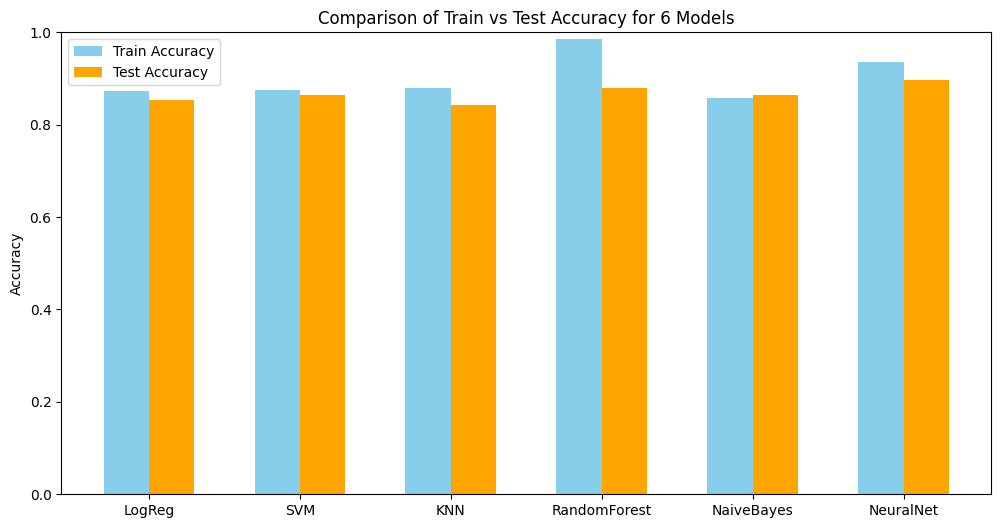

In [29]:
# Logistic Regression
y_train_pred_lr = best_model_lr.predict(X_train)
y_test_pred_lr = best_model_lr.predict(X_test)

# SVM
y_train_pred_svm = best_model_svm.predict(X_train)
y_test_pred_svm = best_model_svm.predict(X_test)

# KNN
y_train_pred_knn = best_model_knn.predict(X_train)
y_test_pred_knn = best_model_knn.predict(X_test)

# Random Forest
y_train_pred_rf = best_model_rf.predict(X_train)
y_test_pred_rf = best_model_rf.predict(X_test)

# Naive Bayes
y_train_pred_nb = gnb.predict(X_train)
y_test_pred_nb = gnb.predict(X_test)

# Neural Network
final_model.eval()
with torch.no_grad():
    y_train_pred_nn = (final_model(X_train_tensor) > 0.5).float()
    y_test_pred_nn = (final_model(X_test_tensor) > 0.5).float()


train_acc = [
    accuracy_score(y_train, y_train_pred_lr),
    accuracy_score(y_train, y_train_pred_svm),
    accuracy_score(y_train, y_train_pred_knn),
    accuracy_score(y_train, y_train_pred_rf),
    accuracy_score(y_train, y_train_pred_nb),
    accuracy_score(y_train, y_train_pred_nn),
]

test_acc = [
    accuracy_score(y_test, y_test_pred_lr),
    accuracy_score(y_test, y_test_pred_svm),
    accuracy_score(y_test, y_test_pred_knn),
    accuracy_score(y_test, y_test_pred_rf),
    accuracy_score(y_test, y_test_pred_nb),
    accuracy_score(y_test, y_test_pred_nn),
]

models = ["LogReg", "SVM", "KNN", "RandomForest", "NaiveBayes", "NeuralNet"]


x = range(len(models))
plt.figure(figsize=(12, 6))
plt.bar(
    [i - 0.15 for i in x], train_acc, width=0.3, label="Train Accuracy", color="skyblue"
)
plt.bar(
    [i + 0.15 for i in x], test_acc, width=0.3, label="Test Accuracy", color="orange"
)
plt.xticks(x, models)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Comparison of Train vs Test Accuracy for 6 Models")
plt.legend()
plt.show()

# So model Random forest and Neural Network have better accuracy resluts on this data

In [30]:
torch.save(final_model.state_dict(), "best_model.pth")
print("Model weights saved successfully!")

Model weights saved successfully!


In [31]:
loaded_model = AdvancedNN(
    input_dim,
    hidden1=best_params["hidden1"],
    hidden2=best_params["hidden2"],
    dropout_rate=best_params["dropout_rate"],
)

loaded_model.load_state_dict(torch.load("best_model.pth"))
loaded_model.eval()
print("Model loaded successfully!")

Model loaded successfully!


# Prediction by new data

In [32]:
new_data = {
    "Age": [55],
    "Sex": ["M"],
    "ChestPainType": ["ATA"],
    "RestingBP": [140],
    "Cholesterol": [250],
    "FastingBS": [0],
    "RestingECG": ["Normal"],
    "MaxHR": [150],
    "ExerciseAngina": ["N"],
    "Oldpeak": [1.5],
    "ST_Slope": ["Up"],
}
new_df = pd.DataFrame(new_data)
# Seperate numerical and categorial features
numeric_cols = new_df.select_dtypes(include="number").columns
categorical_cols = new_df.select_dtypes(include="object").columns

# normalize
new_numeric = scaler.transform(new_df[numeric_cols])
new_numeric = pd.DataFrame(new_numeric, columns=numeric_cols)

# One-Hot Encode
new_categorical = ohe.transform(new_df[categorical_cols])
new_categorical = pd.DataFrame(
    new_categorical.toarray(), columns=ohe.get_feature_names_out()
)

new_features = pd.concat([new_numeric, new_categorical], axis=1)

In [33]:
new_tensor = torch.tensor(new_features.values, dtype=torch.float32)
# prediction
loaded_model.eval()
with torch.no_grad():
    prediction = (loaded_model(new_tensor) > 0.5).float()

print("Prediction (0=No HeartDisease, 1=HeartDisease):", int(prediction.item()))

Prediction (0=No HeartDisease, 1=HeartDisease): 0
